In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
import statistics

In [3]:
data0 = pd.read_csv("round4\prices_round_4_day_1.csv", sep = ";")
data1 = pd.read_csv("round4\prices_round_4_day_2.csv", sep = ";")
data2 = pd.read_csv("round4\prices_round_4_day_3.csv", sep = ";")
all_data = pd.concat([data0, data1, data2], axis=0)

In [26]:
# Black-Scholes formula for European call options
def black_scholes(S, K, T, r, sigma):
    dist = statistics.NormalDist(mu=0.0, sigma=1.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * dist.cdf(d1) - K * np.exp(-r * T) * dist.cdf(d2)
    return C

# Objective function to minimize
def objective(params, S, K, T, C_observed):
    r, sigma = params
    C_predicted = black_scholes(S, K, T, r, sigma)
    return np.sum((C_observed - C_predicted) ** 2)

In [32]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    C = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return C

Optimal risk-free rate (r): 0.0000
Optimal volatility (sigma): 0.1923
5439284.359529914


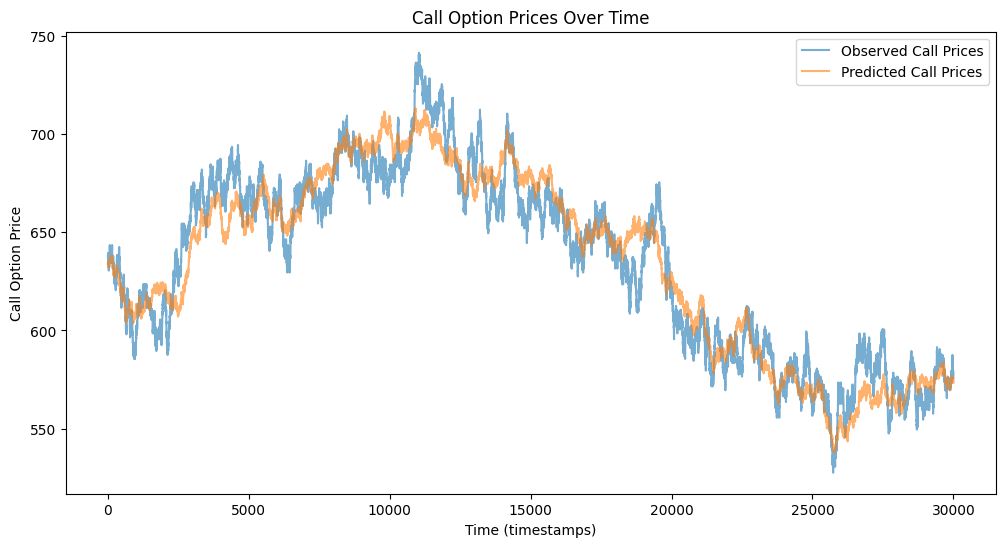

In [39]:
coupon = all_data[all_data['product']=="COCONUT_COUPON"]['mid_price'].to_numpy()
coconut = all_data[all_data['product']=="COCONUT"]['mid_price'].to_numpy()
obs_per_day = 10000
days = 3
total_samples = days * obs_per_day
timestamps = np.arange(total_samples)
maturity_days = 250
T = 250 / 365.25
K = 10000
initial_guess = [0.1, 0.25]

result = minimize(objective, initial_guess, args=(coconut, K, T, coupon), bounds=((0, 0.2), (0.1, 0.5)))
if result.success:
    fitted_r, fitted_sigma = result.x
    print(f"Optimal risk-free rate (r): {fitted_r:.4f}")
    print(f"Optimal volatility (sigma): {fitted_sigma:.4f}")

    # Predict call prices using fitted parameters
    C_predicted = black_scholes(coconut, K, T, fitted_r, fitted_sigma)

    # Calculate residuals
    residuals = coupon - C_predicted
    print(np.sum((coupon - C_predicted) ** 2))
    # Plotting the results
    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, coupon, label='Observed Call Prices', alpha=0.6)
    plt.plot(timestamps, C_predicted, label='Predicted Call Prices', alpha=0.6)
    plt.title('Call Option Prices Over Time')
    plt.xlabel('Time (timestamps)')
    plt.ylabel('Call Option Price')
    plt.legend()
    plt.show()
else:
    print("Optimization failed:", result.message)

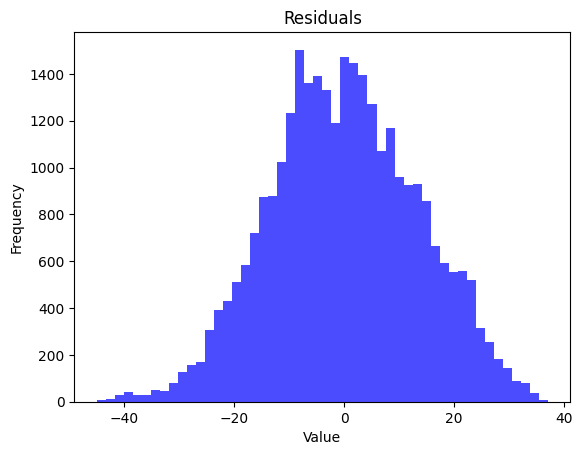

In [40]:
residuals
# Create the histogram
plt.hist(residuals, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins here

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Residuals')

# Show the plot
plt.show()

In [41]:
print(residuals.std())

13.465114799465114


In [65]:
data0 = pd.read_csv("round2\prices_round_2_day_-1.csv", sep = ";")
data1 = pd.read_csv("round2\prices_round_2_day_0.csv", sep = ";")
data2 = pd.read_csv("round2\prices_round_2_day_1.csv", sep = ";")
all_data = [data0, data1, data2]
# all_data = pd.concat([data0, data1, data2], axis=0)
# data0.head()

In [109]:
def prepare_trading_signals_and_pnl(prices, lo, hi, window):
    # Calculate RSI
    rsi = calculate_rsi(prices, window)
    buy_signals = rsi < lo
    sell_signals = rsi > hi
    
    # Define positions based on signals
    # positions = pd.Series(index=prices.index, data=np.nan)
    # positions[buy_signals] = 1
    # positions[sell_signals] = 0
    # positions.ffill(inplace=True)
    # positions.fillna(0, inplace=True)
    
    # # Calculate P&L
    # price_changes = prices.diff()
    # pnl = positions.shift(1) * price_changes  # Shift because buy/sell happens at the end of the day
    # cumulative_pnl = pnl.cumsum()
    
    # return prices, buy_signals, sell_signals, cumulative_pnl
    positions = pd.Series(index=prices.index, data=np.nan)
    
    currently_holding = False  # This tracks whether the last position was a buy (True) or sell (False)
    executed_buys = pd.Series(data=False, index=prices.index)
    executed_sells = pd.Series(data=False, index=prices.index)
    for i in range(len(prices)):
        if buy_signals[i] and not currently_holding:
            positions[i] = 1
            executed_buys[i] = True
            currently_holding = True
        elif sell_signals[i] and currently_holding:
            positions[i] = 0
            executed_sells[i] = True
            currently_holding = False
    
    positions.ffill(inplace=True)
    positions.fillna(0, inplace=True)  # Ensuring no positions are held before the first buy
    
    # Calculate P&L
    price_changes = prices.diff()
    pnl = positions.shift(1) * price_changes  # Shift because buy/sell happens at the end of the day
    cumulative_pnl = pnl.cumsum()
    
    return prices, executed_buys, executed_sells, cumulative_pnl
# def plot_signals_and_pnl(prices, buy_signals, sell_signals, cumulative_pnl, ax1, ax2):
#     # Plot Midprice with Buy and Sell Signals
#     ax1.plot(prices, label='Midprice', color='blue')
#     ax1.scatter(prices[buy_signals].index, prices[buy_signals], color='green', label='Buy Signal', marker='^', s=100)
#     ax1.scatter(prices[sell_signals].index, prices[sell_signals], color='red', label='Sell Signal', marker='v', s=100)
#     ax1.legend()

#     # Plot Cumulative P&L
#     ax2.plot(cumulative_pnl, label='Cumulative P&L', color='purple')
#     ax2.legend()

def plot_signals_and_pnl(prices, executed_buys, executed_sells, cumulative_pnl, ax1, ax2):
    # Plot Midprice with Buy and Sell Signals
    ax1.plot(prices, label='Midprice', color='blue')
    ax1.scatter(prices[executed_buys].index, prices[executed_buys], color='green', label='Buy Signal', marker='^', s=100)
    ax1.scatter(prices[executed_sells].index, prices[executed_sells], color='red', label='Sell Signal', marker='v', s=100)
    ax1.legend()

    # Plot Cumulative P&L
    ax2.plot(cumulative_pnl, label='Cumulative P&L', color='purple')
    ax2.legend()


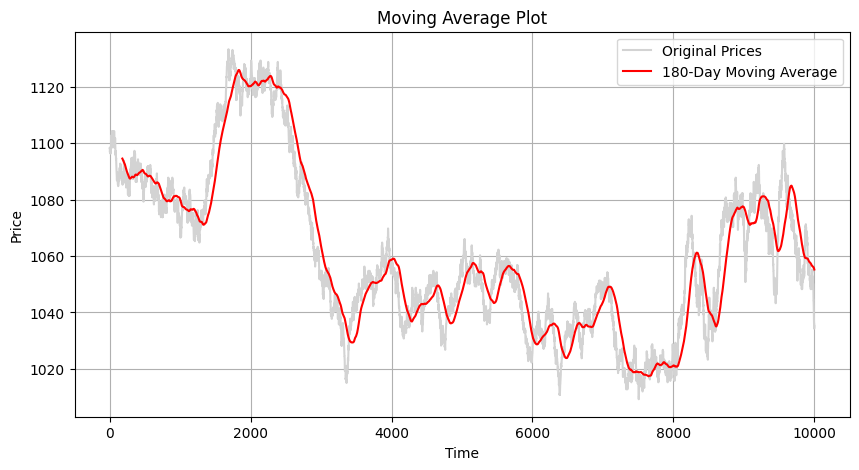

In [162]:
from statsmodels.tsa.seasonal import STL
prices = data2['ORCHIDS']
def plot_moving_average(prices, window, title='Moving Average Plot'):
    # Calculate the moving average
    moving_avg = prices.rolling(window=window).mean()

    # Plotting the data
    plt.figure(figsize=(10, 5))
    plt.plot(prices, label='Original Prices', color='lightgray')
    plt.plot(moving_avg, label=f'{window}-Day Moving Average', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(prices, 180)

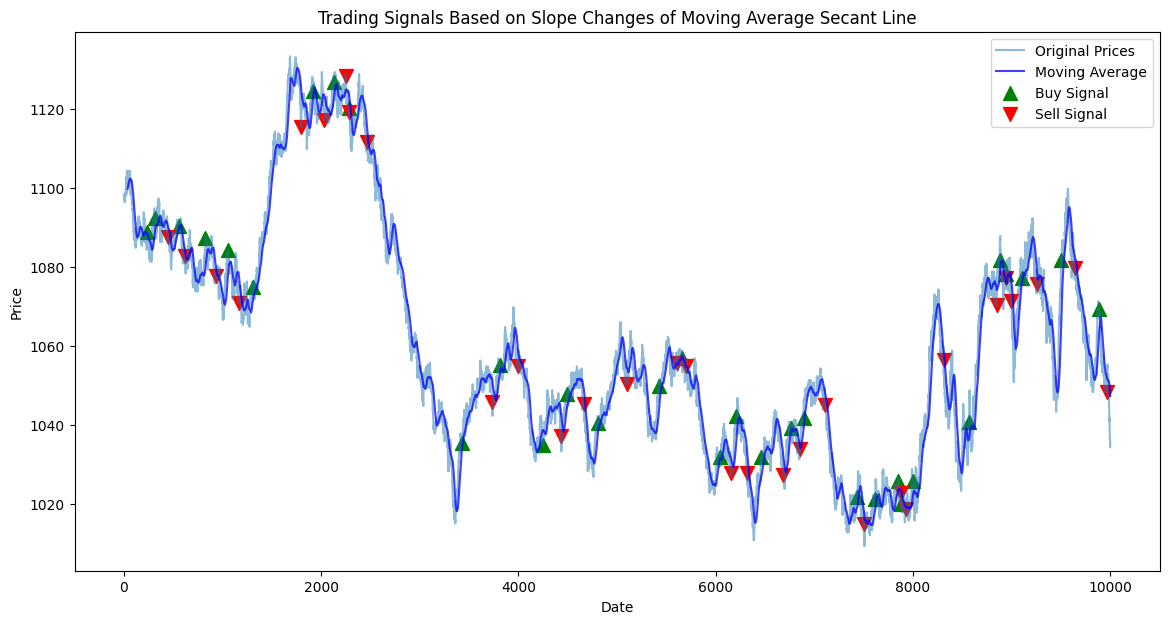

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_slope_of_secant(ma, window):
    # Create a Series to hold the slope of each window
    slopes = pd.Series(index=ma.index, dtype=float)
    
    # Calculate the slope for each window where possible
    for i in range(window, len(ma)):
        # Calculate the slope from the first point in the window to the last
        y2 = ma.iloc[i]          # Last point in the window
        y1 = ma.iloc[i - window] # First point in the window
        slopes.iloc[i] = (y2 - y1) / window
    
    return slopes

def plot_trading_signals(prices, ma, slopes):
    # Detect signals
    slope_changes = np.sign(slopes).diff()
    buy_signals = (slope_changes == 2)  # Change from negative to positive
    sell_signals = (slope_changes == -2) # Change from positive to negative
    
    plt.figure(figsize=(14, 7))
    plt.plot(prices, label='Original Prices', alpha=0.5)
    plt.plot(ma, label='Moving Average', color='blue', alpha=0.75)
    
    # Plotting buy signals
    plt.scatter(prices[buy_signals].index, prices[buy_signals], color='green', label='Buy Signal', marker='^', s=100)
    # Plotting sell signals
    plt.scatter(prices[sell_signals].index, prices[sell_signals], color='red', label='Sell Signal', marker='v', s=100)
    
    plt.title('Trading Signals Based on Slope Changes of Moving Average Secant Line')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example data
prices = data2['ORCHIDS']
ma = prices.rolling(window=40).mean()

# Calculate the slope of the secant lines
slopes = calculate_slope_of_secant(ma, 110)

# Plot the results
plot_trading_signals(prices, ma, slopes)

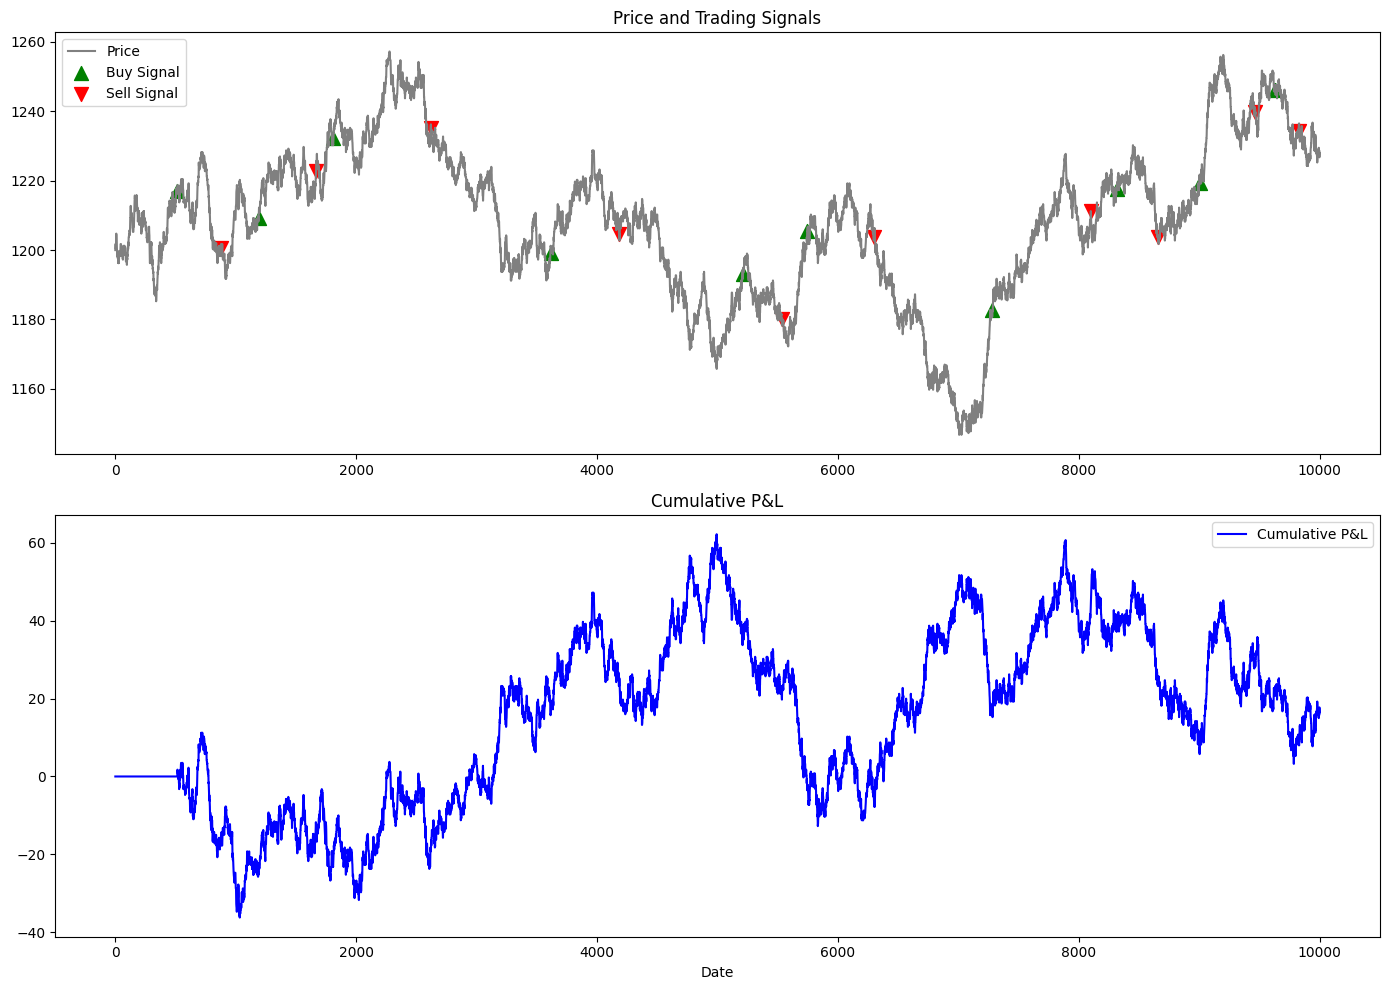

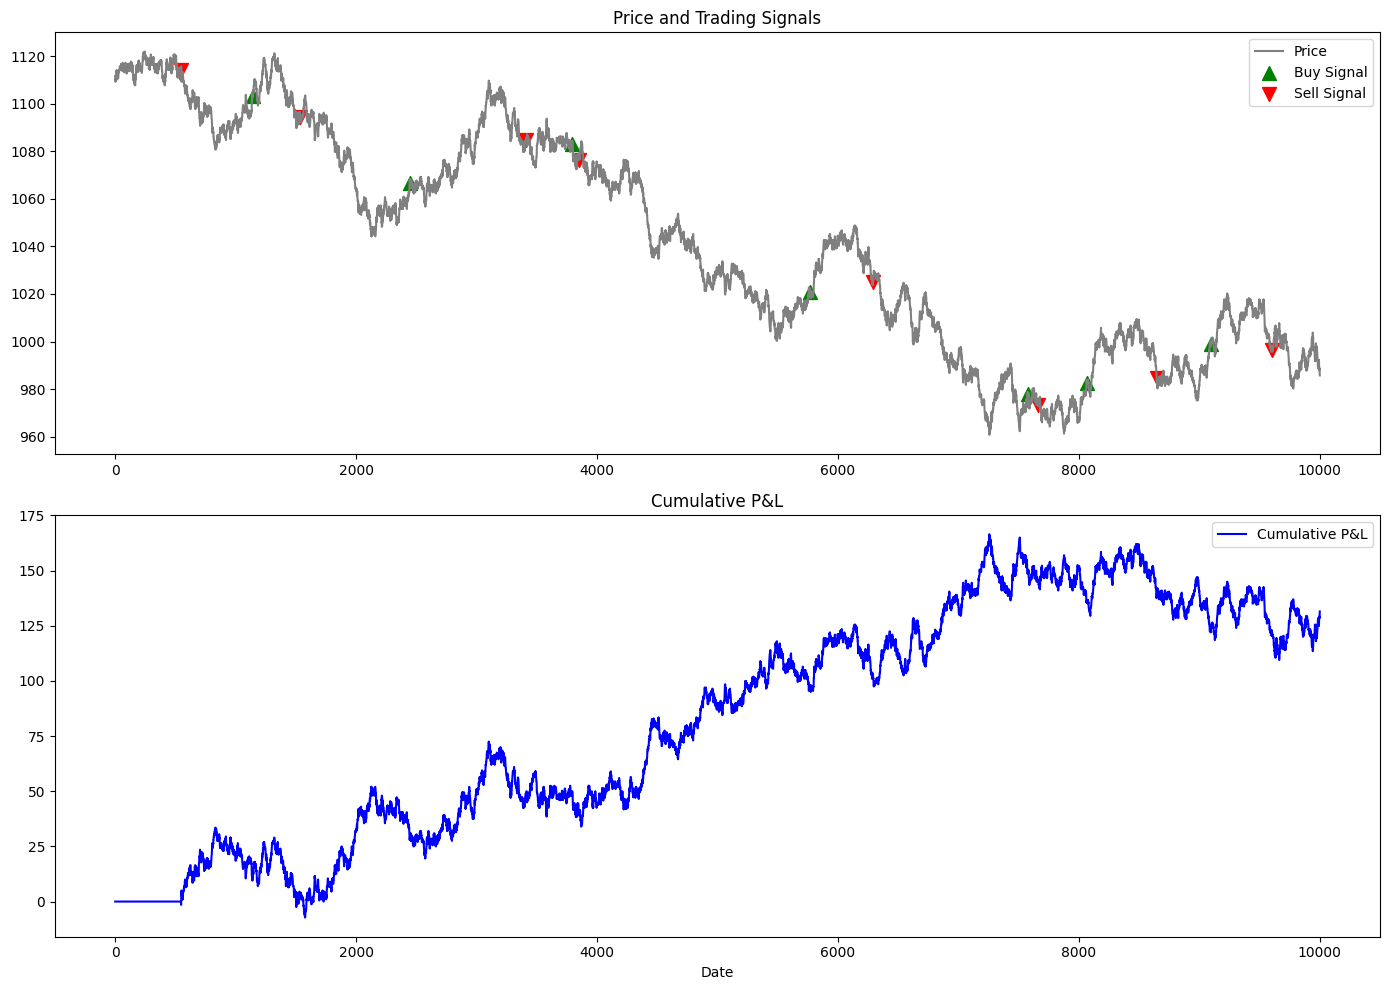

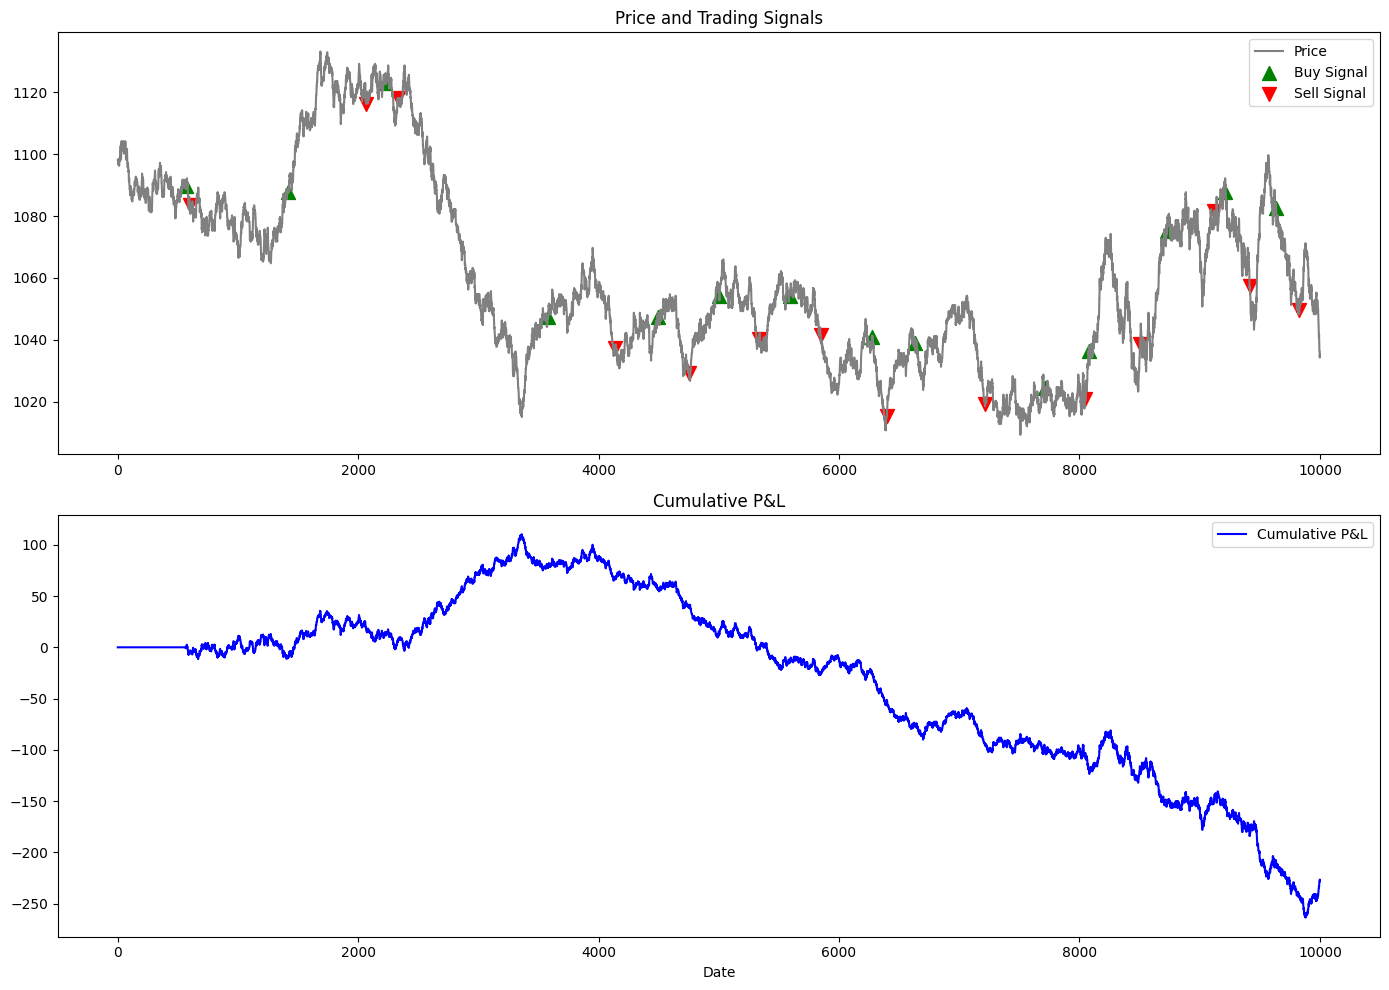

-79.5


In [226]:
def calculate_slope_of_secant(ma, window):
    slopes = pd.Series(index=ma.index, dtype=float)
    for i in range(window, len(ma)):
        y2 = ma.iloc[i]
        y1 = ma.iloc[i - window]
        slopes.iloc[i] = (y2 - y1) / window
    return slopes

def calculate_trading_signals(slopes):
    # Detect changes in the slope's sign to determine buy and sell signals
    slope_changes = np.sign(slopes).diff()
    buy_signals = (slope_changes > 0) & (np.sign(slopes.shift(1)) == -1)
    sell_signals = (slope_changes < 0) & (np.sign(slopes.shift(1)) == 1)
    return buy_signals, sell_signals

def simulate_trades(prices, buy_signals, sell_signals):
    # Simulate trading based on buy and sell signals
    positions = pd.Series(index=prices.index, data=np.nan)
    positions[buy_signals] = 1
    positions[sell_signals] = -1
    positions = positions.ffill().fillna(0)

    # Calculate P&L
    pnl = positions.shift(1) * prices.diff()  # P&L calculation
    return pnl.cumsum()  # Cumulative P&L

def plot_results(prices, buy_signals, sell_signals, cumulative_pnl):
    plt.figure(figsize=(14, 10))

    # Plot prices and signals
    ax1 = plt.subplot(211)
    prices.plot(ax=ax1, color='gray', label='Price')
    ax1.scatter(prices[buy_signals].index, prices[buy_signals], color='green', marker='^', s=100, label='Buy Signal')
    ax1.scatter(prices[sell_signals].index, prices[sell_signals], color='red', marker='v', s=100, label='Sell Signal')
    ax1.set_title('Price and Trading Signals')
    ax1.legend()

    # Plot cumulative P&L
    ax2 = plt.subplot(212)
    cumulative_pnl.plot(ax=ax2, color='blue', label='Cumulative P&L')
    ax2.set_title('Cumulative P&L')
    ax2.set_xlabel('Date')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Example data
# Example data
opt_pnl = -1
opt_ma_w, opt_slope_w = 0, 0

pnl = 0
for df in all_data:
    prices = df['ORCHIDS']
    ma = prices.rolling(window=300).mean()
    slopes = calculate_slope_of_secant(ma, 180)
    # plot_trading_signals(prices, ma, slopes)
    buy_signals, sell_signals = calculate_trading_signals(slopes)
    cumulative_pnl = simulate_trades(prices, buy_signals, sell_signals)
    pnl += cumulative_pnl.tail(1).iloc[0]
    plot_results(prices, buy_signals, sell_signals, cumulative_pnl)
print(pnl)

# for i in range(0, 180, 5)

# Plot the results


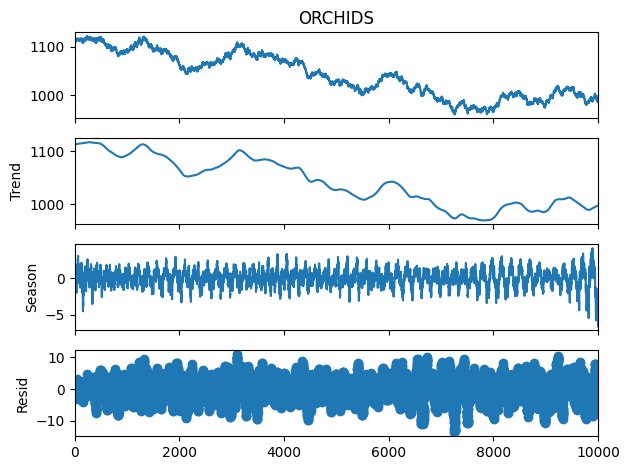

In [157]:
from statsmodels.tsa.seasonal import STL
stl = STL(prices, seasonal=13, period = 180)
res = stl.fit()
fig = res.plot()

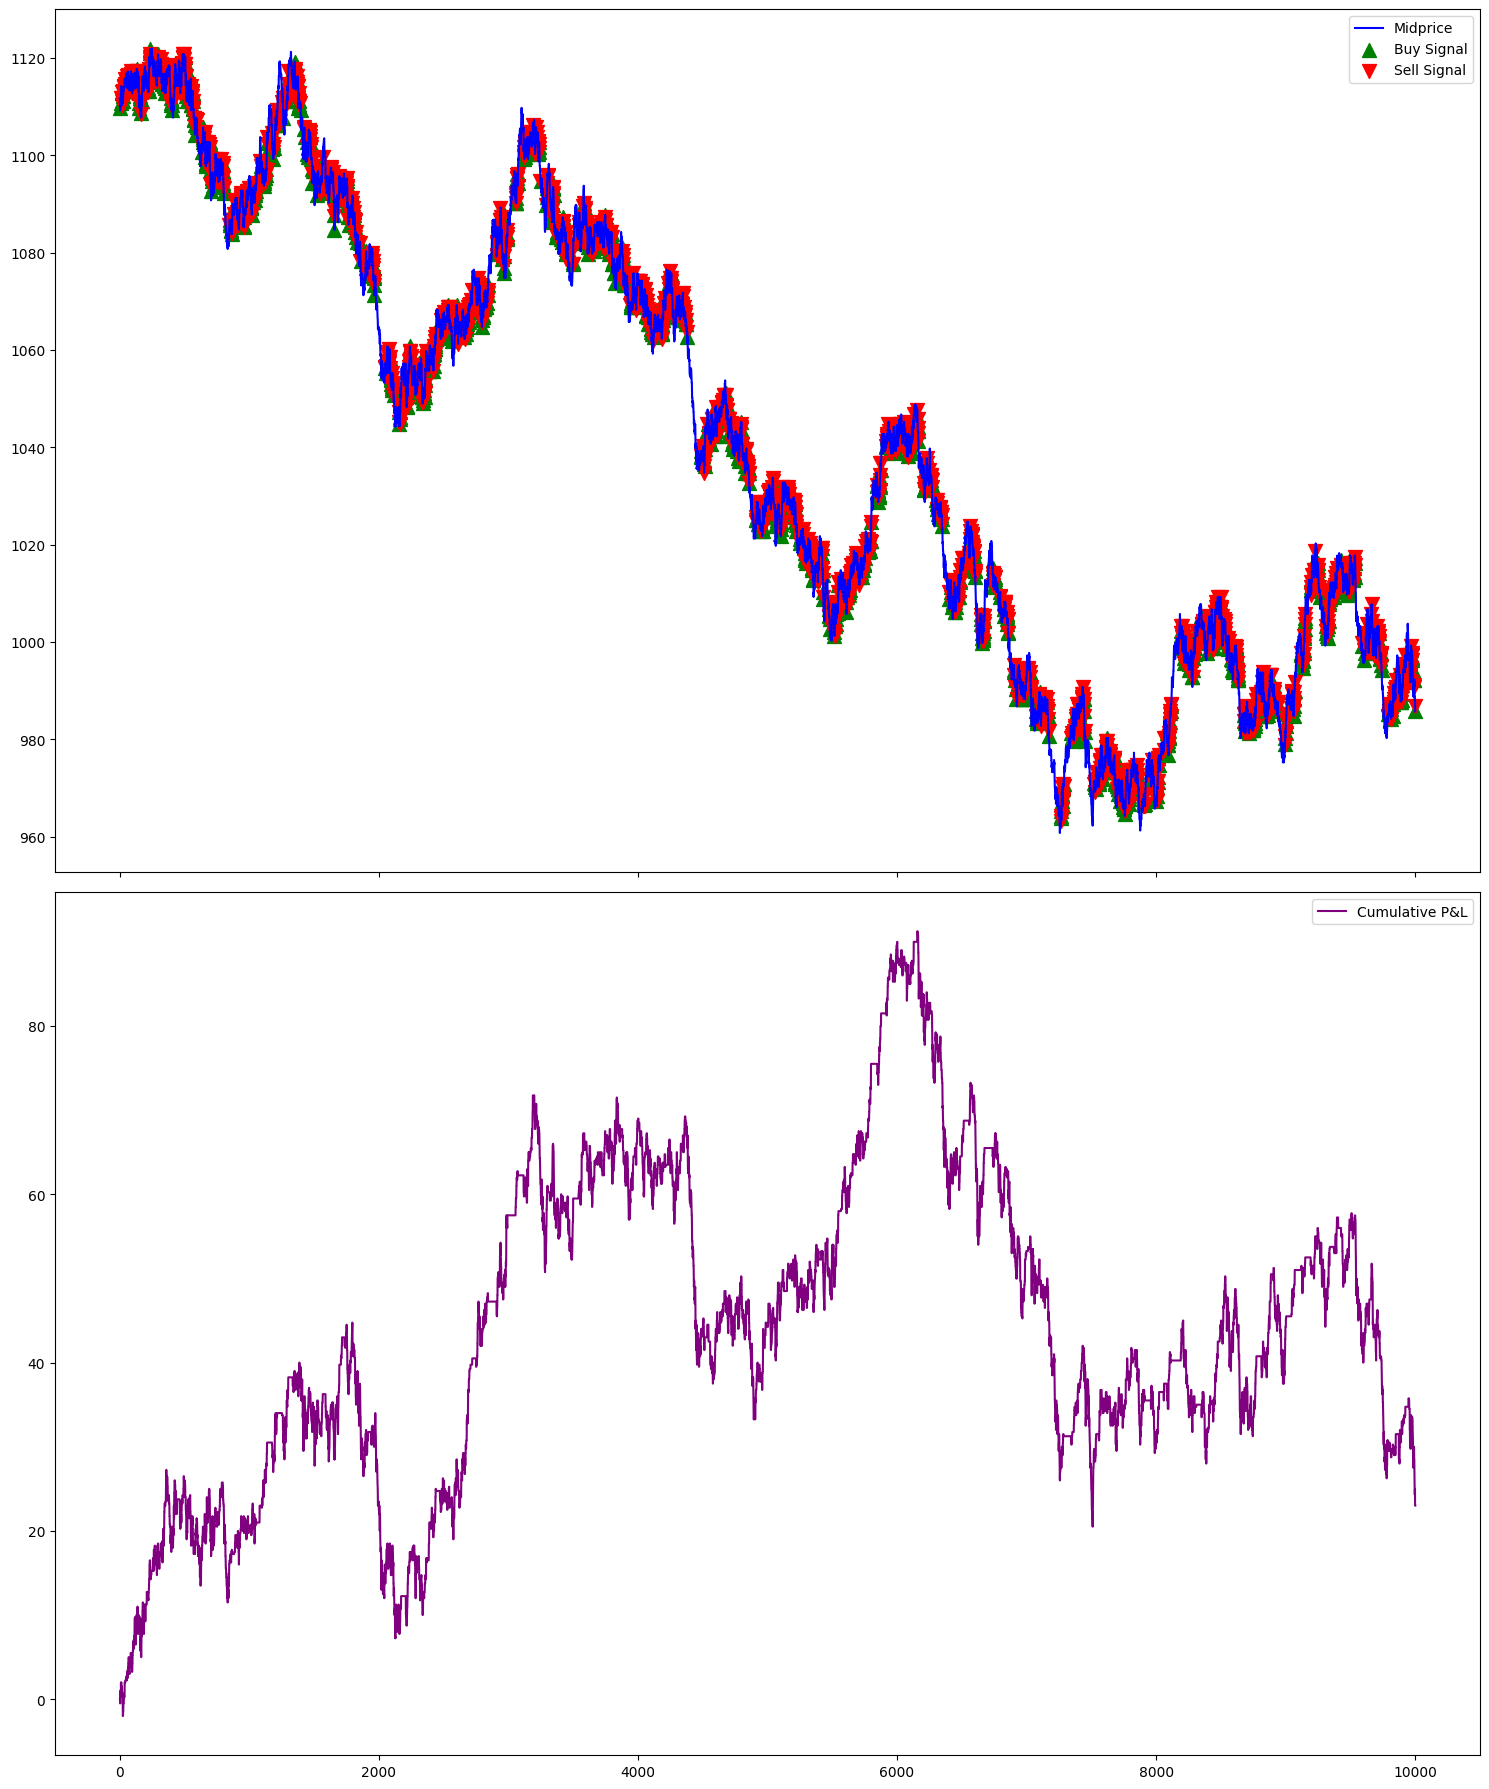

In [149]:
fig, axs = plt.subplots(2, 1, figsize=(15, 18), sharex=True)  # 6 plots: 3 price signal plots and 3 pnl plots

# Assuming df1, df2, df3 are your DataFrames for different days

def calc_opt_pnl(df):
    opt_lo, opt_hi, opt_window = -1, -1, -1
    opt_pnl = -1
    for lo in range(0, 100, 3):
        for hi in range(0, 100, 3):
            for window in range(1, 200, 5):
                prices, buy_signals, sell_signals, cumulative_pnl = prepare_trading_signals_and_pnl(df, lo, hi, window)
                final_pnl = cumulative_pnl.tail(1).iloc[0]
                if final_pnl > opt_pnl:
                    opt_pnl = final_pnl
                    opt_lo, opt_hi, opt_window = lo, hi, window
                    print((lo, hi, window))
    return lo, hi, window, opt_pnl

df = data1['ORCHIDS']
# print(calc_opt_pnl(df))
prices, buy_signals, sell_signals, cumulative_pnl = prepare_trading_signals_and_pnl(df, 57, 42, 41)
final_pnl = cumulative_pnl.tail(1).iloc[0]
final_pnl
plot_signals_and_pnl(prices, buy_signals, sell_signals, cumulative_pnl, axs[0], axs[1])

plt.tight_layout()
plt.show()

In [ ]:
plt.plot()

In [91]:
def calculate_rsi(data, window=14):
    """Calculate the Relative Strength Index (RSI) for a given Pandas Series and window period."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [89]:
prices = data0["ORCHIDS"]
rsi = calculate_rsi(prices)
buy_signals = rsi > 60
sell_signals = rsi < 40
prices.reset_index(drop=True, inplace=True)
prices

0        1200.00
1        1201.75
2        1201.75
3        1201.75
4        1201.75
          ...   
9996     1227.75
9997     1226.75
9998     1227.75
9999     1228.00
10000    1228.00
Name: ORCHIDS, Length: 10001, dtype: float64

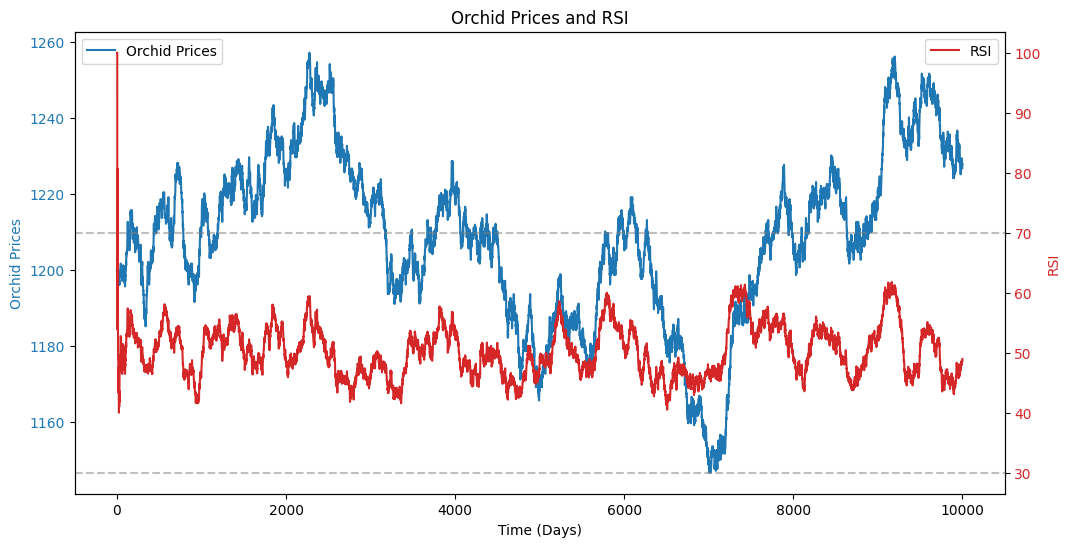

In [90]:

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the orchid prices on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Time (Days)')
ax1.set_ylabel('Orchid Prices', color=color)
ax1.plot(prices.index, prices, label='Orchid Prices', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the RSI
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RSI', color=color)
ax2.plot(rsi.index, rsi, label='RSI', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(70, linestyle='--', alpha=0.5, color='gray')  # Overbought line
ax2.axhline(30, linestyle='--', alpha=0.5, color='gray')  # Oversold line

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Orchid Prices and RSI')
plt.show()

In [63]:
positions = pd.Series(index=prices.index, data=np.nan)
positions[buy_signals] = 0
positions[sell_signals] = 1

# Forward fill the positions to simulate holding the stocks
positions.ffill(inplace=True)
positions.fillna(0, inplace=True)  # No position before the first buy

# Calculate daily changes in price
price_changes = prices.diff()

# Calculate P&L by positions held
pnl = positions.shift(1) * price_changes  # Shift positions because the decision to buy/sell is made at the end of the day
cumulative_pnl = pnl.cumsum()

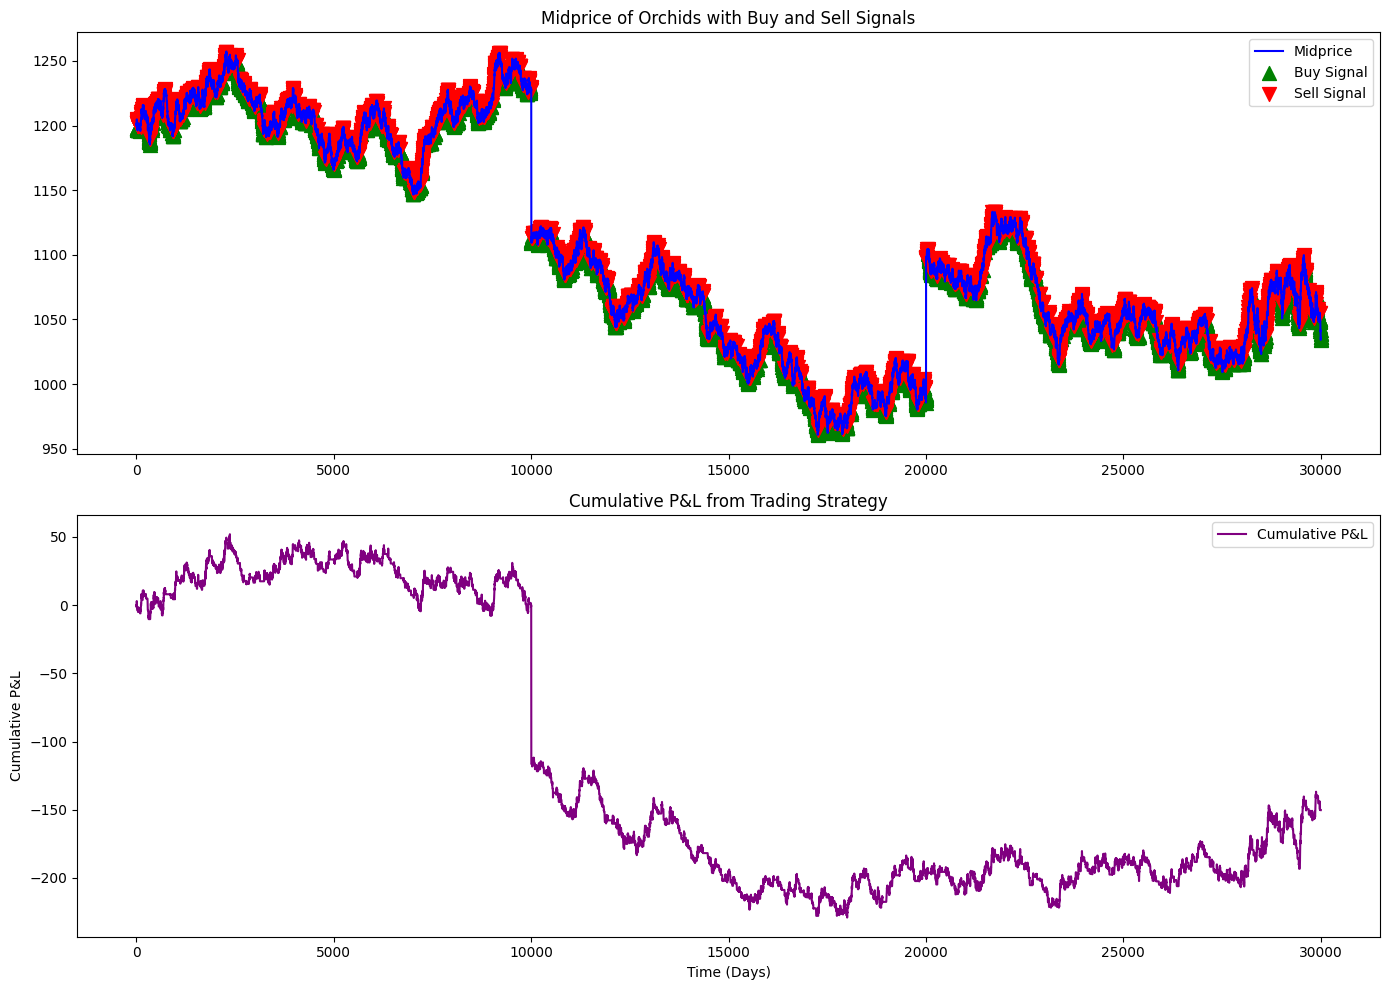

In [64]:
plt.figure(figsize=(14, 10))

# Plot Midprices with Buy and Sell Signals
plt.subplot(211)
plt.plot(prices, label='Midprice', color='blue')
plt.title('Midprice of Orchids with Buy and Sell Signals')
plt.scatter(prices[buy_signals].index, prices[buy_signals], color='green', label='Buy Signal', marker='^', s=100)
plt.scatter(prices[sell_signals].index, prices[sell_signals], color='red', label='Sell Signal', marker='v', s=100)
plt.legend()

# Plot Cumulative P&L
plt.subplot(212)
plt.plot(cumulative_pnl, label='Cumulative P&L', color='purple')
plt.title('Cumulative P&L from Trading Strategy')
plt.xlabel('Time (Days)')
plt.ylabel('Cumulative P&L')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Create lagged features
num_lags = 10
for col in ['SUNLIGHT', 'HUMIDITY']:
    for lag in range(1, num_lags + 1):
        all_data[f'{col}_lag_{lag}'] = all_data[col].shift(lag)

# Calculate percent change for the future price
all_data['ORCHIDS_future'] = all_data['ORCHIDS'].shift(-1)
all_data['percent_change'] = (all_data['ORCHIDS_future'] - all_data['ORCHIDS']) / all_data['ORCHIDS'] * 100

C:\Users\yixiu\AppData\Local\Temp\ipykernel_28208\3115197900.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data[f'{col}_lag_{lag}'] = all_data[col].shift(lag)
C:\Users\yixiu\AppData\Local\Temp\ipykernel_28208\3115197900.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['ORCHIDS_future'] = all_data['ORCHIDS'].shift(-1)
C:\Users\yixiu\AppData\Local\Temp\ipykernel_28208\3115197900.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [31]:
all_data = all_data.dropna()

In [32]:
all_data

,timestamp,ORCHIDS,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,DAY,ORCHIDS_lag_1,ORCHIDS_lag_2,...,HUMIDITY_lag_7,HUMIDITY_lag_8,ORCHIDS_future,percent_change,ORCHIDS_lag_9,ORCHIDS_lag_10,SUNLIGHT_lag_9,SUNLIGHT_lag_10,HUMIDITY_lag_9,HUMIDITY_lag_10
48,4800,1201.25,1.4,9.5,-2.0,2479.0808,79.21805,-1,1201.75,1201.75,...,79.183550,79.178696,1201.25,0.000000,1198.25,1199.25,2481.9453,2482.2932,79.173860,79.169044
49,4900,1201.25,1.4,9.5,-2.0,2478.7920,79.22305,-1,1201.25,1201.75,...,79.188420,79.183550,1201.00,-0.020812,1199.25,1198.25,2481.6035,2481.9453,79.178696,79.173860
50,5000,1201.00,1.4,9.5,-2.0,2478.5088,79.22807,-1,1201.25,1201.25,...,79.193310,79.188420,1200.25,-0.062448,1199.25,1199.25,2481.2676,2481.6035,79.183550,79.178696
51,5100,1200.25,1.4,9.5,-2.0,2478.2317,79.23311,-1,1201.00,1201.25,...,79.198230,79.193310,1200.25,0.000000,1199.75,1199.25,2480.9375,2481.2676,79.188420,79.183550
52,5200,1200.25,1.4,9.5,-2.0,2477.9602,79.23817,-1,1200.25,1201.00,...,79.203156,79.198230,1200.75,0.041658,1201.25,1199.75,2480.6133,2480.9375,79.193310,79.188420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,999300,1041.75,0.9,9.5,-5.0,2299.9160,69.88776,1,1040.75,1042.75,...,69.778496,69.763130,1039.75,-0.191985,1049.75,1050.25,2299.9100,2299.9163,69.747826,69.732580
9994,999400,1039.75,0.9,9.5,-5.0,2299.9238,69.90361,1,1041.75,1040.75,...,69.793920,69.778496,1038.75,-0.096177,1050.00,1049.75,2299.9050,2299.9100,69.763130,69.747826
9995,999500,1038.75,0.9,9.5,-5.0,2299.9330,69.91952,1,1039.75,1041.75,...,69.809410,69.793920,1036.25,-0.240674,1048.75,1050.00,2299.9014,2299.9050,69.778496,69.763130
9996,999600,1036.25,0.9,9.5,-5.0,2299.9436,69.93549,1,1038.75,1039.75,...,69.824960,69.809410,1036.25,0.000000,1048.25,1048.75,2299.8992,2299.9014,69.793920,69.778496


In [33]:
# Define predictors and the target variable
X = all_data[[f'{col}_lag_{lag}' for col in ['SUNLIGHT', 'HUMIDITY'] for lag in range(1, num_lags + 1)]]
y = all_data['percent_change']

# Add a constant to the model (intercept)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [34]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         percent_change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4387
Date:                Sun, 14 Apr 2024   Prob (F-statistic):              0.985
Time:                        23:07:51   Log-Likelihood:                 19241.
No. Observations:               29952   AIC:                        -3.844e+04
Df Residuals:                   29931   BIC:                        -3.827e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0006      0.007     

In [5]:
def calc_qty(orderlist):
    qty = 0
    max_qty_availble = 0
    opt_ask = -1
    for (i,j) in orderlist:
        qty += j
        if j > max_qty_availble:
            max_qty_availble = j
            opt_ask = i
    return opt_ask

prices = []
X, y = [], []
n_steps = 8
for df in all_data:
    arrays = df.apply(lambda row: convert_row_to_arrays(row), axis=1)
    for i in arrays:
        bids = sorted(i[0], reverse=True)
        asks = sorted(i[1])
        opt_ask = calc_qty(asks)
        opt_bid = calc_qty(bids)
        midpx = (opt_ask + opt_bid) / 2
        prices.append(midpx)
    for i in range(len(prices)):
        end_ix = i + n_steps
        if end_ix > len(prices)-1:
            break
        seq_x, seq_y = prices[i:end_ix], prices[end_ix]
        X.append(seq_x)
        y.append(seq_y)


In [6]:
X = np.array(X)
y = np.array(y)
X[9000]

array([5062.5, 5062.5, 5063.5, 5063.5, 5064.5, 5064.5, 5063.5, 5063.5])

In [7]:
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.550e+07
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:30:41   Log-Likelihood:                -52125.
No. Observations:               59976   AIC:                         1.043e+05
Df Residuals:                   59967   BIC:                         1.043e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9532      0.453      2.103      0.0

In [15]:
model = ARIMA(prices, order=(8,2,1))
model_fit = model.fit()

In [16]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(8, 1, 1)   Log Likelihood              -27338.030
Date:                Thu, 11 Apr 2024   AIC                          54696.060
Time:                        03:33:42   BIC                          54779.149
Sample:                             0   HQIC                         54722.720
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1098      0.969     -0.113      0.910      -2.009       1.790
ar.L2         -0.0122      0.216     -0.056      0.955      -0.435       0.410
ar.L3         -0.0104      0.037     -0.283      0.7